In [ ]:
# IMPORTING COSMOS20020 PROCESSED FITS on data object (astropy table)

import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table 
from matplotlib import colormaps
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity #KDE
import tqdm # progress bar
from time import sleep

data = Table.read('COSMOS2020_Farmer_processed_ACS.fits')

'''
for column in data.colnames: # To read columns in data table
    print(column)
'''

In [2]:
# Print with LaTeX typography. TeX Live package is needed.

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer modern"],  # You can change the serif font here if needed
    "axes.labelsize": 12,     # Adjust as needed
    "axes.linewidth": 0.5,    # Adjust line width if necessary
    "xtick.labelsize": 12,    # Adjust tick label size
    "ytick.labelsize": 12,    # Adjust tick label size
    "legend.fontsize": 12,    # Adjust legend font size
    "legend.handlelength": 2.0
})

In [3]:
# 'lp_type' indicates type of object. Galaxies are classified with a 0.
# Info: LePhare type (0: galaxy, 1: star, 2: Xray sour., -9: failure in fit) (Source: https://irsa.ipac.caltech.edu/data/COSMOS/gator_docs/cosmos2020c_colDescriptions.html)

# As we want to map galaxy clusters and galaxy density using KDE, we must remove all objects non galaxies. We use mask() method.

mask = (data['lp_type'] == 0)
data2 = data[mask]

# We also want to remove faint galaxies. The criteria will be that those galaxies with magnitude in i band larger than 24.5 will be removed.

mask2 = (data2['HSC_i_MAG'] < 24.5)
selected_data = data2[mask2]

In [4]:
print('In total, we are left with '+str(len(selected_data))+' galaxies.')

selected_data # print data table

In total, we are left with 122621 galaxies.


<Table length=122621>
  ID           RA         ...     HSC_i_MAG          HSC_z_MAG     
              deg         ...                                      
int64       float64       ...      float64            float64      
------ ------------------ ... ------------------ ------------------
    12 150.47680901653771 ... 23.998657968251823 23.904690272816406
    73 149.46802469745458 ... 22.488625781260154 22.310945994949265
    74 150.48803484813715 ... 23.773712743566357  23.69448486421106
    85 150.47643625963255 ...  23.77698609110483 23.471011887641243
   104 149.47572212535283 ... 24.486278661926654 23.865337581415044
   129  150.7246863030431 ... 24.336994144413186  24.26916578356796
   134 149.46234400518523 ... 24.112798939209444 23.084729596773336
   140  149.4694773151735 ...   21.8773110931319 21.829865784574878
   141  149.6379350206623 ... 23.891807685145913  23.68953164713729
   ...                ... ...                ...                ...
964421 150.21037710038223 ...  18.67352691279642 18.362104461805306
964422 150.20975135296376 ... 23.135074818400394 22.837884105315766
964423 150.20975598889393 ...  22.77805926604872 22.354190591273312
964424 150.20805868881368 ... 19.836237604672046 19.550016556203488
964426 150.20332522501397 ... 23.493760170378163 23.317228972052554
964427 150.20262304268869 ...    23.453757775694 22.389422760811986
964428 150.20660766537725 ...  22.68160360177925 22.501635182184636
964429  150.2116778471035 ... 23.255424316203413 23.527623090463532
964437  150.2020795128472 ...  24.38531470603471 23.223149269941466

In [5]:
# Let's define the minimum and maximum values of both axis.

xmin = min(selected_data['RA'])
xmax = max(selected_data['RA'])

ymin = min(selected_data['DEC'])
ymax = max(selected_data['DEC'])

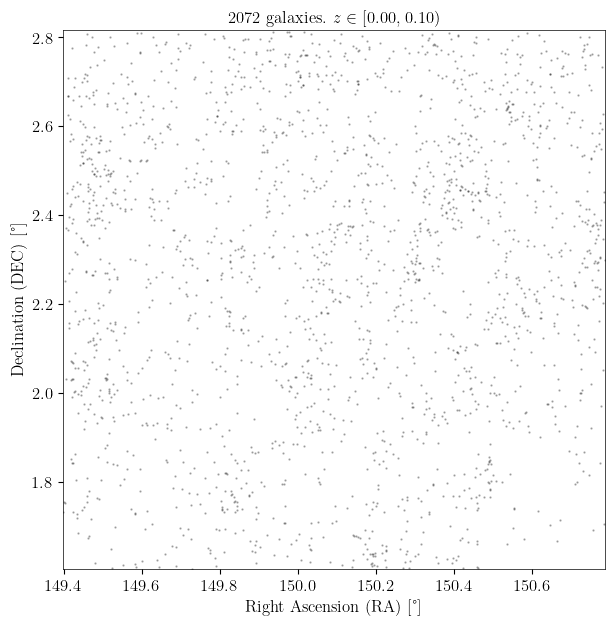

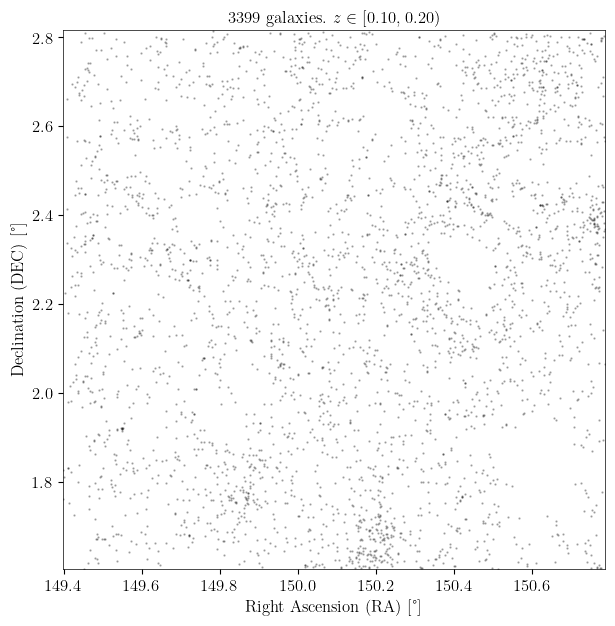

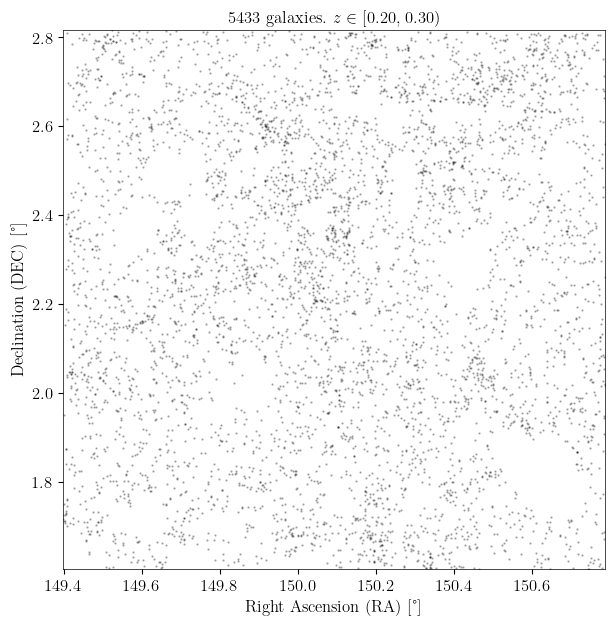

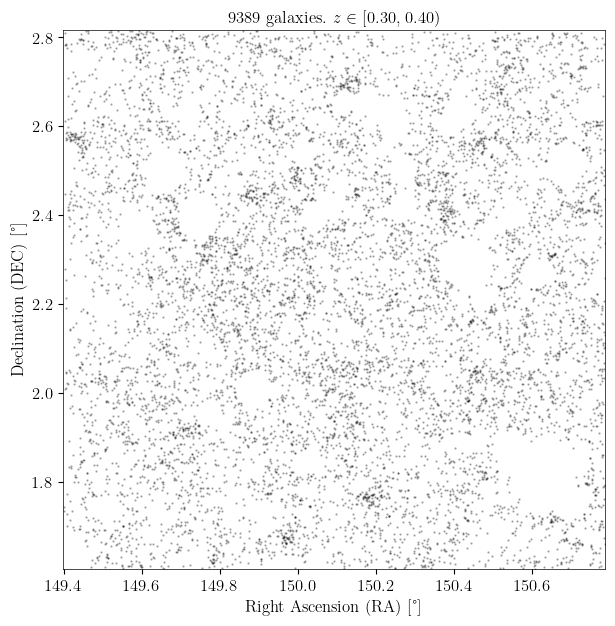

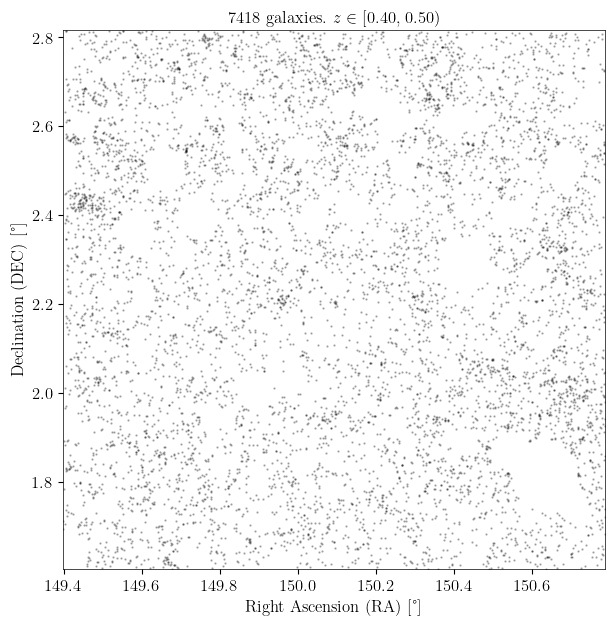

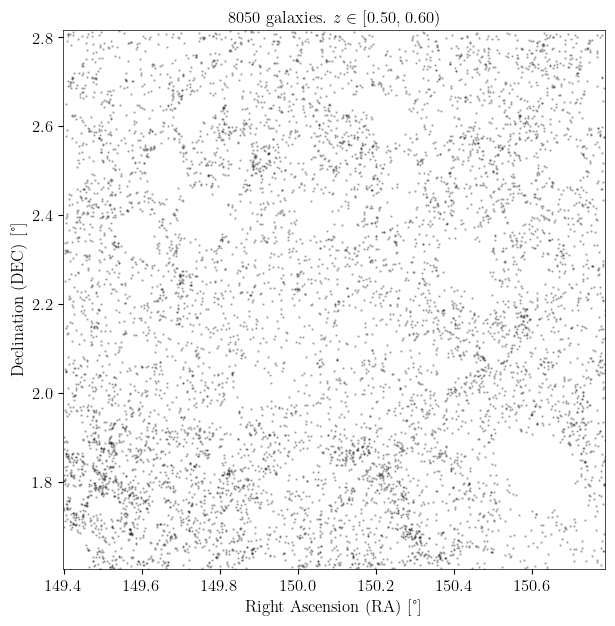

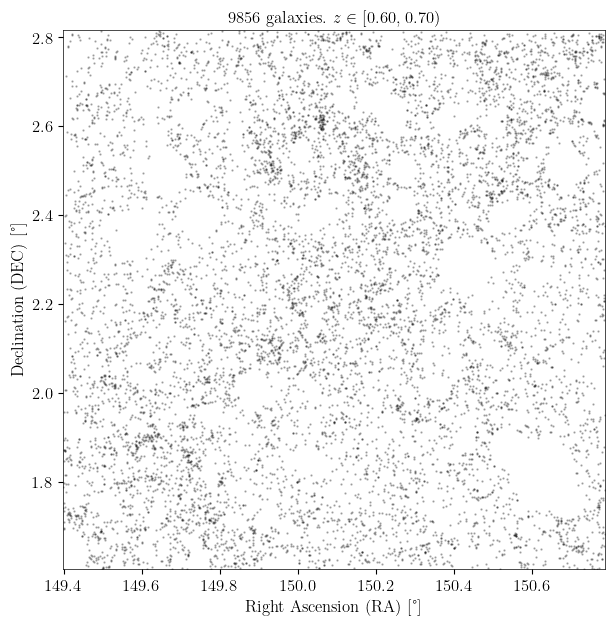

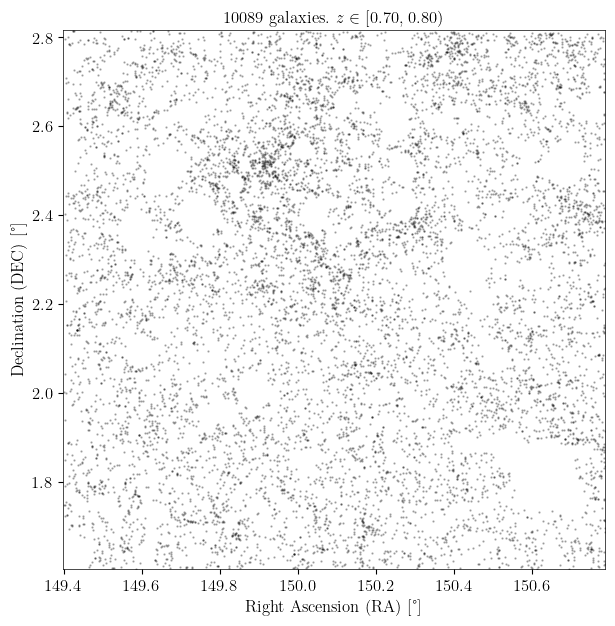

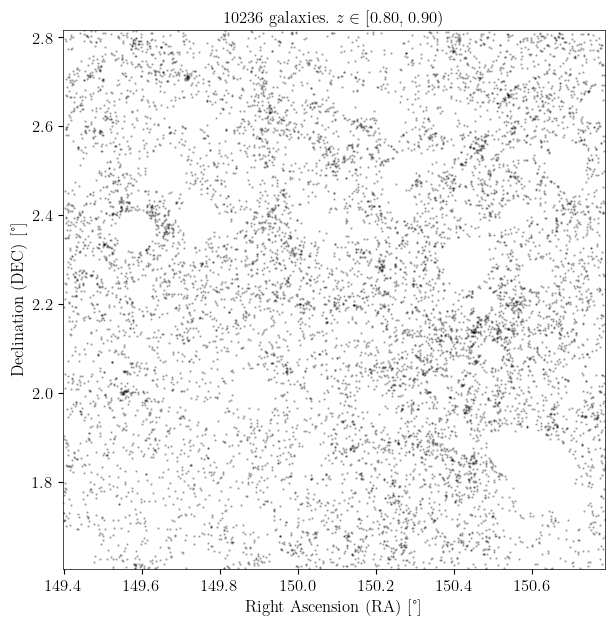

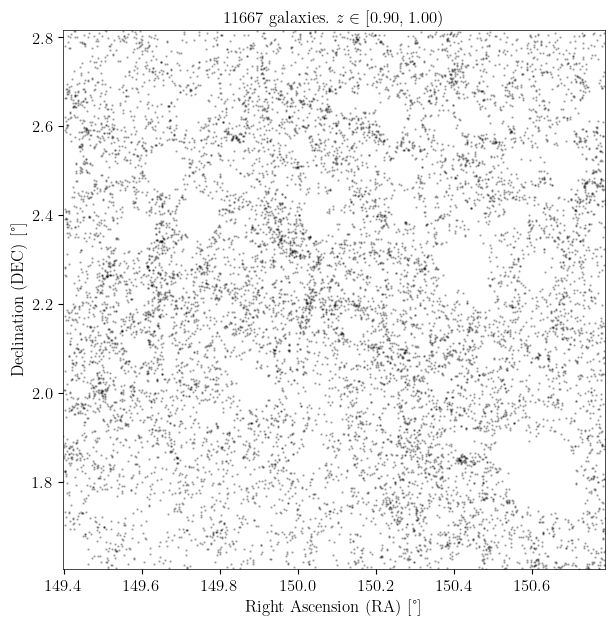

In [50]:
# PRINT SOME GALAXIES ON A PLOT, USING DEC & RA coordinates. Without mapping with KDE.
# Redshifts on 'photoz' were calculated using LePhare algorithm.

z = 0
Delta_z = 0.1
steps = 10 # Several steps can be done, plotting galaxies at Delta_z redshift intervals1

for s in range(steps):
    z += Delta_z

    X = []
    Y = []
    
    mask = (round(z-Delta_z,2) <= selected_data['photoz']) & (selected_data['photoz'] < z)
    selected_redshifts = selected_data[mask]

    for i in range(len(selected_redshifts)):
        X.append(selected_redshifts['RA'][i]) # Right ascension coordinate
        Y.append(selected_redshifts['DEC'][i]) # Declination coordinate

    plt.figure(figsize=(7,7))
    
    plt.scatter(X,Y,color='k',s=0.4,alpha=0.3) # Plot of galaxies with plt.scatter
    
    plt.title(str(len(selected_redshifts))+' galaxies. '+r'$z\in [$'+str("%.02f"%(z-Delta_z))+', '+str("%.02f"%z)+')')
    plt.xlabel('Right Ascension (RA) [°]')
    plt.ylabel('Declination (DEC) [°]')
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    
    plt.show()
    plt.close()

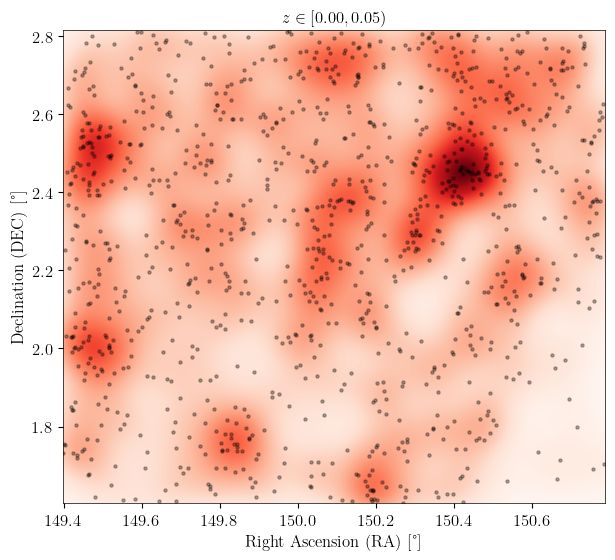

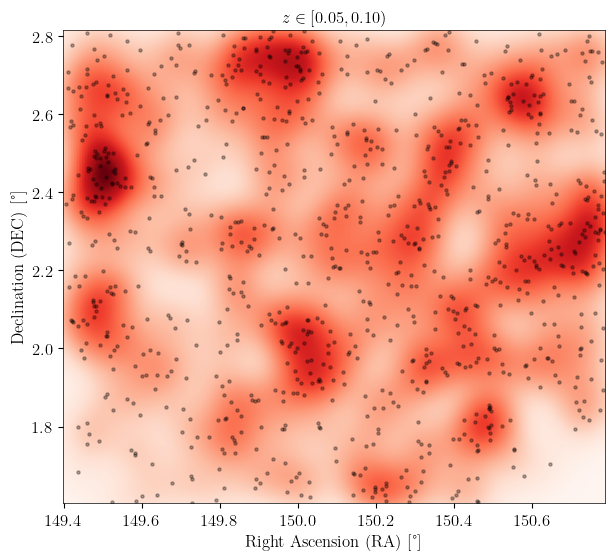

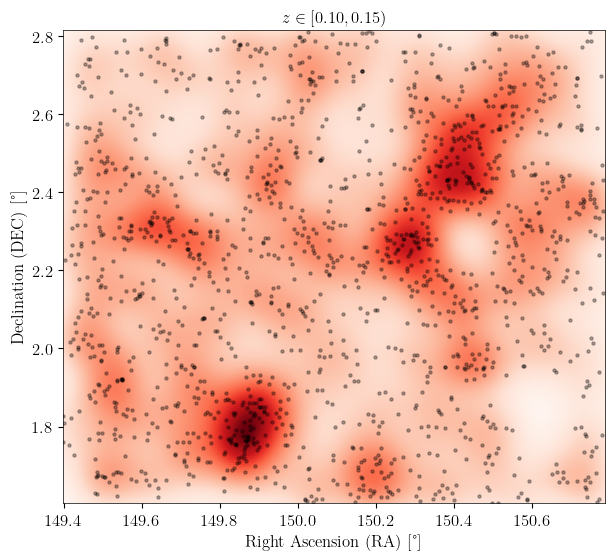

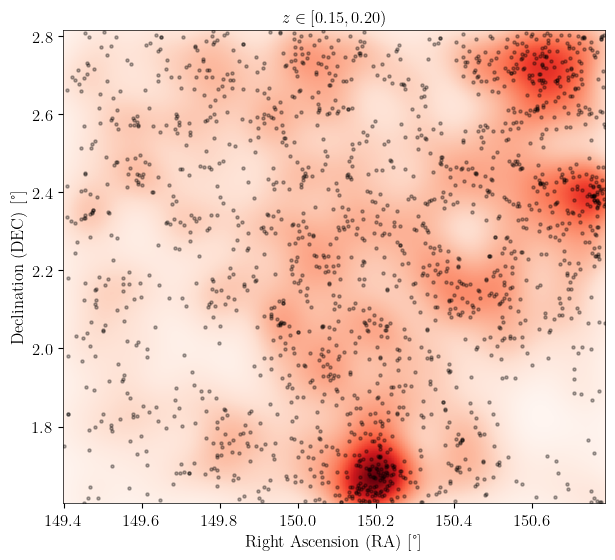

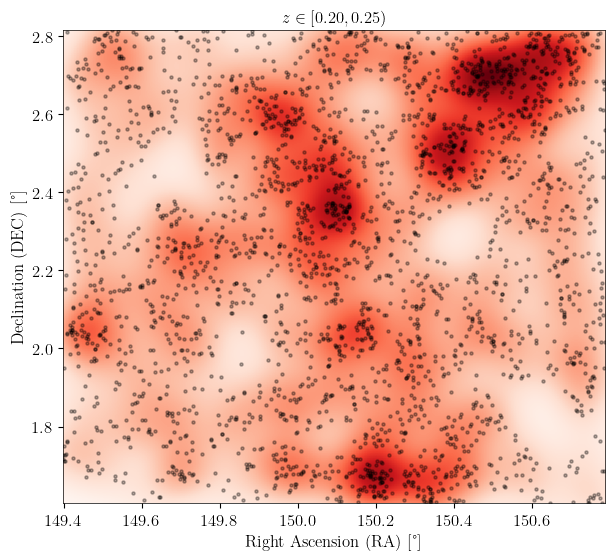

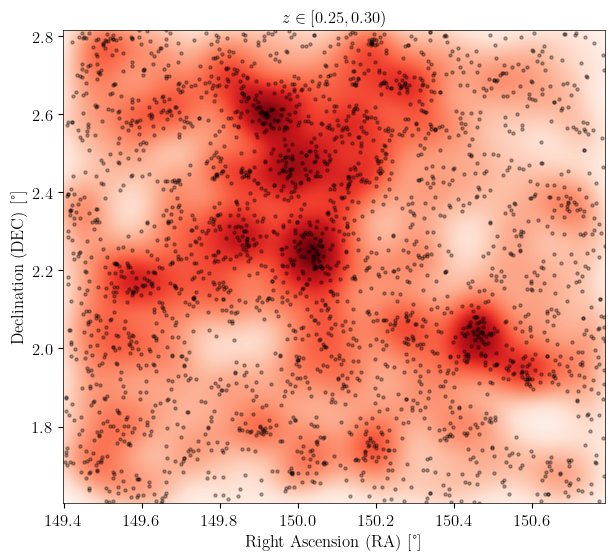

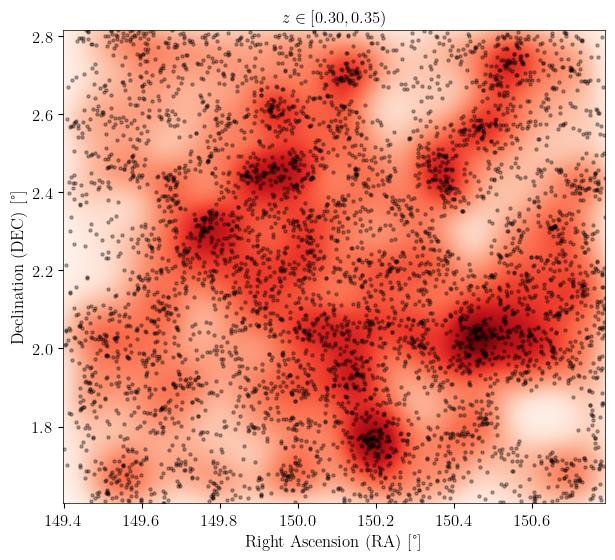

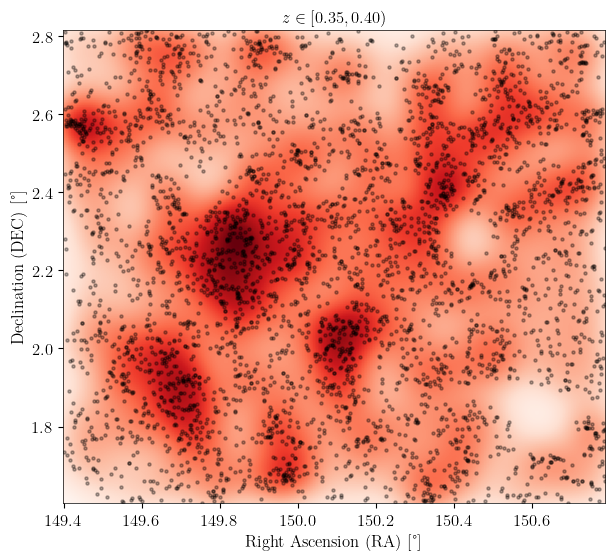

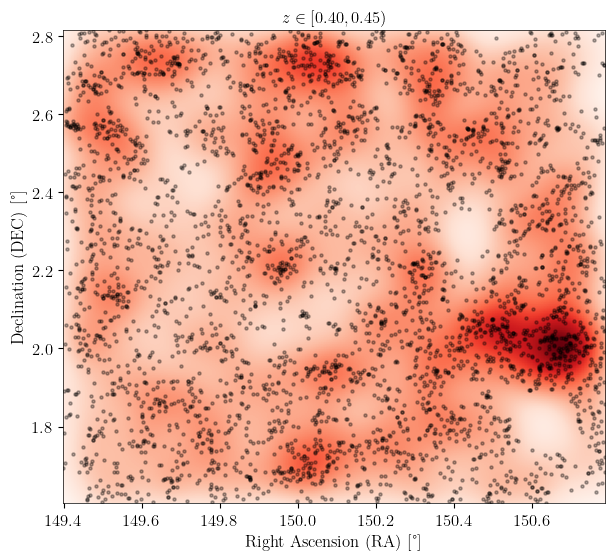

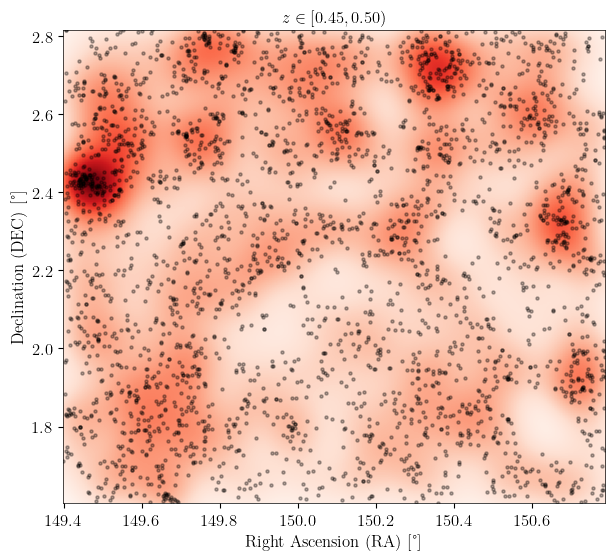

In [49]:
#KERNEL DENSITY ESTIMATION
#https://scikit-learn.org/stable/modules/density.html

#kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(X)

nobj = len(selected_data)
z = 0
Delta_z = 0.05
steps = 10
for s in range(steps):
    z += Delta_z
    
    X_list = []
    Y_list = []

    mask = (z - Delta_z <= selected_data['photoz']) & (selected_data['photoz'] <= z)
    
    X_list = list(selected_data['RA'][mask])
    Y_list = list(selected_data['DEC'][mask])
    
    # From here on part of the code is taken from: https://gist.github.com/daleroberts/7a13afed55f3e2388865b0ec94cd80d2

    # Calculate the point density
    xy = np.vstack([X_list,Y_list]) # It piles up the two 1D arrays (X and Y) to form a 2D array where each column correspond to a galaxy coordinates.
    kde = KernelDensity(bandwidth=0.05, metric='euclidean', # Bandwidth of the kernel controls the smoothness of the KDE.
                        kernel='gaussian', algorithm='ball_tree')
    kde.fit(xy.T) # xy.T transposes data from (2, n) to (n, 2). Now each row correspond to a galaxy coordinates.

    # Grid to plot KDE
    X, Y = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]
    positions = np.vstack([X.ravel(), Y.ravel()])

    # Compute KDE values
    Z = np.reshape(np.exp(kde.score_samples(positions.T)), X.shape)

    fig, ax = plt.subplots(figsize=(7,7))
    
    plt.title(r'$z\in['+"%.02f"%(z-Delta_z)+', '+"%.02f"%z+')$')
    
    plt.xlabel('Right Ascension (RA) [°]')
    plt.ylabel('Declination (DEC) [°]')
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    
    ax.imshow(np.rot90(Z), cmap='Reds',
              extent=[xmin, xmax, ymin, ymax])
    
    ax.scatter(X_list,Y_list,c='k',s=5,alpha=0.3) # Plot all galaxy points using plt.scatter
    
    #plt.savefig("%02d."%s+".png",dpi=100)
    plt.show()
    plt.close()

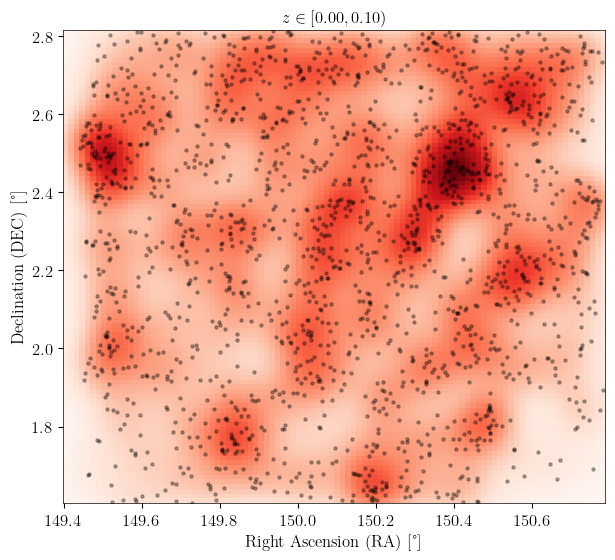

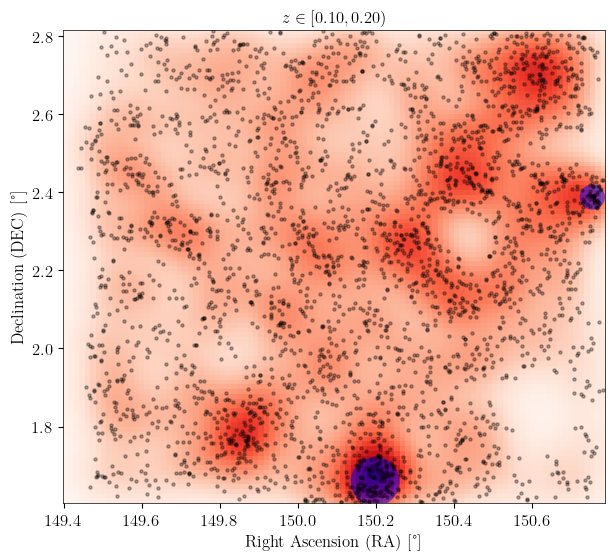

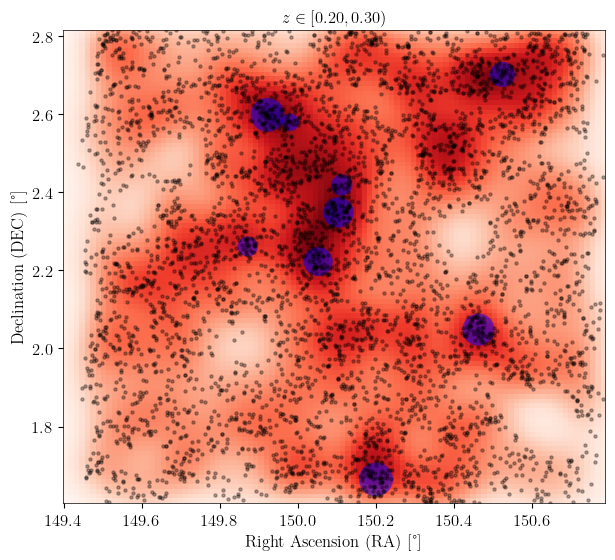

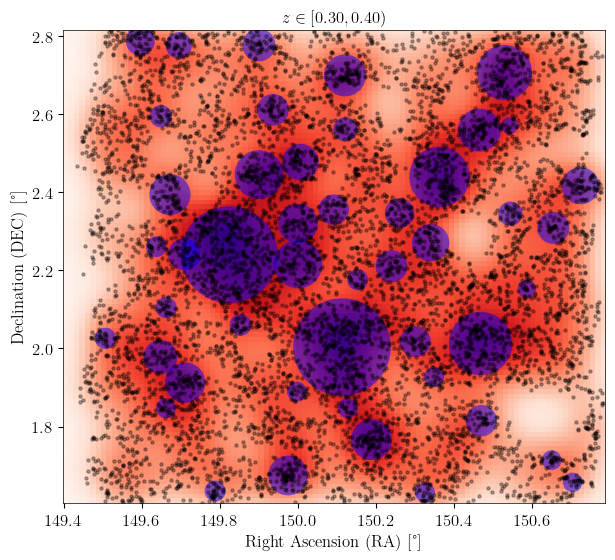

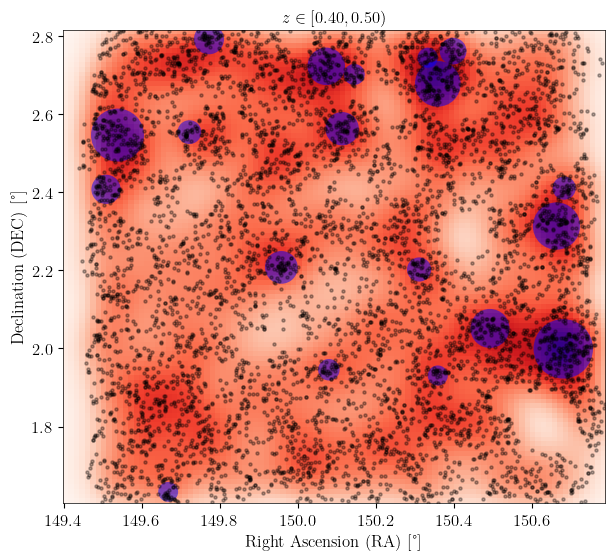

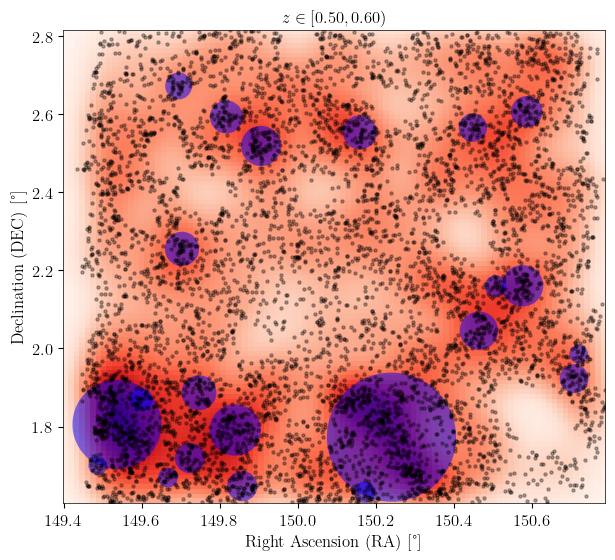

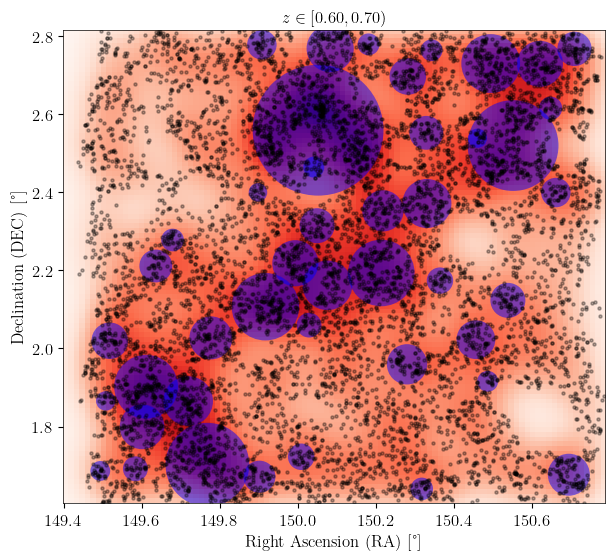

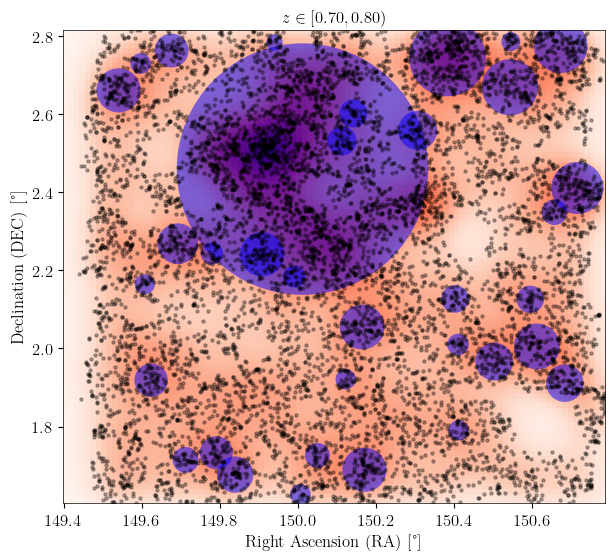

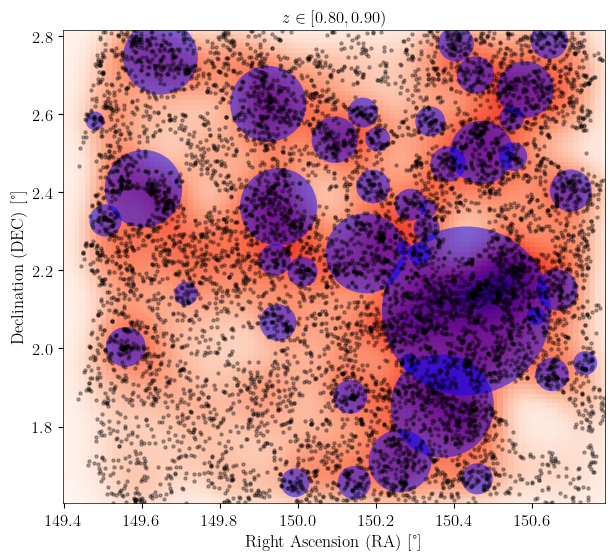

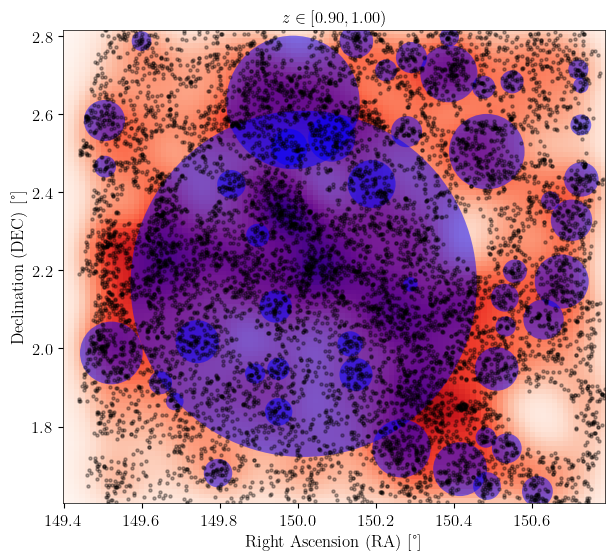

In [74]:
# PLOT OF GALAXY CLUSTERS (in blue) AND ALL GALAXIES (in black)

from sklearn.cluster import DBSCAN

z = 0
Delta_z = 0.1
steps = 10

# As we will use 'ACS_?_WORLD' values, we need to make sure there are no np.nan or masked values in some rows.

nan_mask = np.zeros(len(selected_data), dtype=bool) 

for column in 'AB':
    nan_mask |= np.isnan(selected_data['ACS_' + column + '_WORLD']) # It creates creates a boolean array. True if element is np.NaN. False otherwise.    
    # Operator '|=' indicates that nan_mask updates with iterations.

cleaned_selected_data = selected_data[~nan_mask]

for s in range(steps):
    z += Delta_z
    
    X = []
    Y = []
    A = [] # Semi-major
    B = [] # Semi-minor
    R = [] # Radius (we will approximate an ellipse to a circle)

    mask = (z - Delta_z <= cleaned_selected_data['photoz']) & (cleaned_selected_data['photoz'] <= z)

    X = list(cleaned_selected_data['RA'][mask])
    Y = list(cleaned_selected_data['DEC'][mask])
    A = list(cleaned_selected_data['ACS_A_WORLD'][mask])
    B = list(cleaned_selected_data['ACS_B_WORLD'][mask])
                
    for i in range(len(X)):
        R.append(np.sqrt(float(A[i]*B[i]))) # Calculate radius of galaxy, approximating it to a circle taking semi-major and semi-minor data from COSOMOS2020

    X = np.array(X)
    Y = np.array(Y)
    R = np.array(R)
    
    # From here on part of the code is taken from: https://gist.github.com/daleroberts/7a13afed55f3e2388865b0ec94cd80d2
                 
    # Calculate the point density
    xy = np.vstack([X, Y])
    kde = KernelDensity(bandwidth=0.05, metric='euclidean',
                        kernel='gaussian', algorithm='ball_tree')
    kde.fit(xy.T)

    # Grid to plot KDE
    Xgrid, Ygrid = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([Xgrid.ravel(), Ygrid.ravel()])

    # Compute KDE values
    Z = np.reshape(np.exp(kde.score_samples(positions.T)), Xgrid.shape)

    # Perform DBSCAN clustering
    db = DBSCAN(eps=0.03, min_samples=30).fit(xy.T)
        # eps means distance between two galaxies to consider they are enough close to belong to a same cluster
        # min_samples means minimum of near galaxies required to consider they form a cluster
    labels = db.labels_

    # Number of clusters in labels. We also ignore noise if present (labeled as -1).
    unique_labels = set(labels)
    clusters = [xy[:, labels == k] for k in unique_labels if k != -1]
    cluster_R = [R[labels == k] for k in unique_labels if k != -1]

    fig, ax = plt.subplots(figsize=(7, 7))
    
    # Plot the KDE density map
    ax.imshow(np.rot90(Z), cmap='Reds',
              extent=[xmin, xmax, ymin, ymax])
    ax.axis('on')
    
    # Plot clusters with black circles
    for cluster, r_vals in zip(clusters, cluster_R):
        # Calculate the center of the cluster
        center_x = np.mean(cluster[0])
        center_y = np.mean(cluster[1])

        # Calculate the radius of the cluster based on average angular size
        xmin_cluster = np.min(cluster[0])
        xmax_cluster = np.max(cluster[0])
        ymin_cluster = np.min(cluster[1])
        ymax_cluster = np.max(cluster[1])
        avg_R = np.mean([(xmax_cluster-xmin_cluster)/2,(ymax_cluster-ymin_cluster)/2])
        radius = 1 * avg_R  # Adjust the scaling factor as needed

        # Plot a circle representing the cluster
        circle = plt.Circle((center_x, center_y), radius=radius, color='b', fill=True, linewidth=0, alpha=0.5)
        ax.add_patch(circle)

    # Plot all galaxy points using plt.scatter
    ax.scatter(X,Y,c='k',s=5,alpha=0.3)

    plt.title(r'$z\in ['+"%.02f"%(z - Delta_z)+', '+"%.02f"%z+')$')

    plt.xlabel('Right Ascension (RA) [°]')
    plt.ylabel('Declination (DEC) [°]')
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    
    #plt.savefig("%02d"%s+".png", bbox_inches='tight', dpi=100)

    plt.show()
    plt.close()